In [28]:
using InteractiveUtils, Pkg, Revise
using AdvancedHMC; Pkg.activate(pkgdir(AdvancedHMC) * "/research/tests"); Pkg.instantiate()
versioninfo(); Pkg.status()

  Activating project at `~/.julia/dev/AdvancedHMC/research/tests`


Julia Version 1.9.0-rc2
Commit 72aec423c2a (2023-04-01 10:41 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin21.4.0)
  CPU: 20 × Apple M1 Ultra
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, westmere)
  Threads: 2 on 20 virtual cores
Status `~/.julia/dev/AdvancedHMC/research/tests/Project.toml`
  [c75e803d] AdaptiveRejectionSampling v0.1.1
  [0bf59076] AdvancedHMC v0.4.5
  [6e4b80f9] BenchmarkTools v1.3.2
  [863f3e99] Comonicon v1.0.4
  [163ba53b] DiffResults v1.1.0
  [31c24e10] Distributions v0.25.87
  [366bfd00] DynamicPPL v0.22.2
  [6a86dc24] FiniteDiff v2.19.0
  [f6369f11] ForwardDiff v0.10.35
  [7073ff75] IJulia v1.24.0
  [6d524b87] MCMCDebugging v0.2.1 `https://github.com/TuringLang/MCMCDebugging.jl#master`
  [91a5bcdd] Plots v1.38.9
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
  [e0db7c4e] ReTest v0.3.2
  [37e2e3b7] ReverseDiff v1.14.4
  [a8a75453] StatProfilerHTML v1.5.0
  [8a639fad] VecTargets v0.2.0 `https://github.com/xukai92/VecTargets.jl

In [19]:
using PyPlot: PyPlot; const plt = PyPlot
using Statistics, AdvancedHMC
includet("../src/riemannian_hmc.jl")
includet("../src/riemannian_hmc_utility.jl")

Baseline: HMC with dense but identity Euclidean metric

In [20]:
hps = (; target=:gaussian, n_samples=2_000, metric=:dense_euclidean, λ=1e-2, α=20.0, integrator=:lf, ϵ=0.01, n=6, L=8)
retval = sample_target((; hps...))

@info "Samples" mean(retval.samples) var(retval.samples)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.028665375 (s)
│   h = Hamiltonian(metric=DenseEuclideanMetric(diag=[1.0, 1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, Leapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=Leapfrog(ϵ=0.01), tc=FixedNSteps(8)))
│   EBFMI_est = 1.551026108114739
└   average_acceptance_rate = 0.9999990259792831
┌ Info: Samples
│   mean(retval.samples) =
│    2-element Vector{Float64}:
│     -0.5974409029254605
│      0.08419864347442382
│   var(retval.samples) =
│    2-element Vector{Float64}:
│     0.4658264801808426
└     0.8992307301608482


Check if generalized leapfrog works fine

In [21]:
retval = sample_target((; hps..., integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.099270125 (s)
│   h = Hamiltonian(metric=DenseEuclideanMetric(diag=[1.0, 1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.01, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.551026108114739
└   average_acceptance_rate = 0.9999990259792831
┌ Info: Samples
│   mean(retval.samples) =
│    2-element Vector{Float64}:
│     -0.5974409029254605
│      0.08419864347442382
│   var(retval.samples) =
│    2-element Vector{Float64}:
│     0.4658264801808426
└     0.8992307301608482


Check if RHMC (with Fisher metric) works (on Gaussian)

In [22]:
@time retval = sample_target((; hps..., metric=:dense_riemannian, integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

  4.525942 seconds (11.97 M allocations: 1.084 GiB, 4.66% gc time)


┌ Info: Finished 2000 sampling steps for 1 chains in 4.524633375 (s)
│   h = Hamiltonian(metric=DenseRiemannianMetric(...), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.01, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.5527125607758774
└   average_acceptance_rate = 0.9999990408391768
┌ Info: Samples
│   mean(retval.samples) =
│    2-element Vector{Float64}:
│     -0.5989598854644739
│      0.08398323569960951
│   var(retval.samples) =
│    2-element Vector{Float64}:
│     0.46431084563790753
└     0.8968072920880259


Check if RHMC (with Fisher metric) works for Neal's funnel

In [24]:
using Logging: NullLogger, with_logger

@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian, integrator=:glf))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

LoadError: DomainError with -1.0:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

Check if RHMC with SoftAbs works for Gaussian

In [25]:
@time retval = sample_target((; hps..., metric=:dense_riemannian_softabs, integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

  8.364775 seconds (26.53 M allocations: 1.785 GiB, 5.56% gc time, 55.54% compilation time)


┌ Info: Finished 2000 sampling steps for 1 chains in 4.249326875 (s)
│   h = Hamiltonian(metric=DenseRiemannianMetric(...), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.01, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.5527125607758774
└   average_acceptance_rate = 0.9999990408391768
┌ Info: Samples
│   mean(retval.samples) =
│    2-element Vector{Float64}:
│     -0.5989598854644739
│      0.08398323569960951
│   var(retval.samples) =
│    2-element Vector{Float64}:
│     0.46431084563790753
└     0.8968072920880259


Check if RHMC with SoftAbs works for Neal's funnel

 10.929675 seconds (42.82 M allocations: 2.578 GiB, 6.23% gc time, 27.43% compilation time)


┌ Info: Average acceptance ratio
└   mean(map((s->begin
                #= In[26]:5 =#
                s.is_accept
            end), retval.stats)) = 0.566


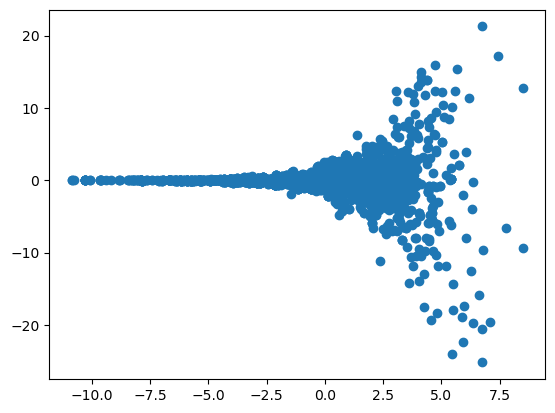

In [26]:
@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, integrator=:glf, ϵ=0.2))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

speed through optimization
- unoptimized: 200s
- +cache 1st loop: 82s
- +cache 2nd loop: 77s
- -copy in ad: 75s
- -rev +fwd: 11s

Check if the Hessian is (semi)-PD for Neal's funnel

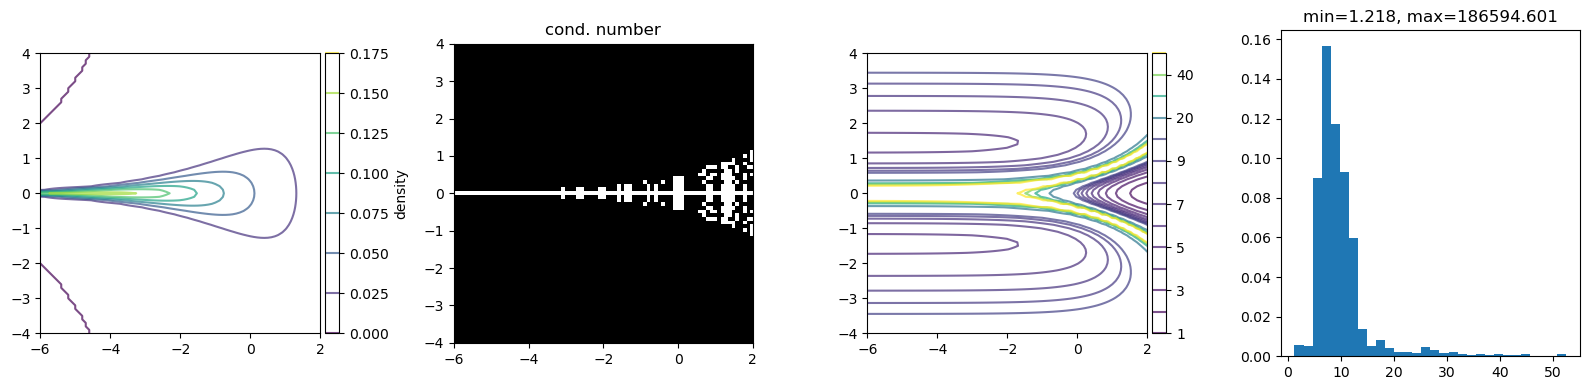

In [29]:
using PyCall: pyimport
using LinearAlgebra: issuccess, cond
using Printf: @sprintf
const axes_grid1 = pyimport("mpl_toolkits.axes_grid1")

isposdef_pivot(A) = issuccess(cholesky(A, Val(true), check=false))

function make_Z(Gfunc, f, λ=0.0)
    is = -6:0.1:+2
    js = -4:0.1:+4
    X = Matrix{Float64}(undef, length(is), length(js))
    Y = Matrix{Float64}(undef, length(is), length(js))
    logdensity = Matrix{Float64}(undef, length(is), length(js))
    Z = Matrix(undef, length(is), length(js))
    for (i, iv) in enumerate(is), (j, jv) in enumerate(js)
        v, _, G = Gfunc([iv, jv])
        X[i,j] = iv
        Y[i,j] = jv
        logdensity[i,j] = exp(-v)
        # PD[i,j] = isposdef(H + λ * I)
        Z[i,j] = f(G + λ * I)
    end
    return logdensity, X, Y, Z
end

function plot_contour!(ax, X, Y, Z, label=nothing; kwargs...)
    contour = ax.contour(X, Y, Z, alpha=0.7; kwargs...)
    divider = axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(contour, cax=cax, ax=ax, orientation="vertical")
    isnothing(label) || cbar.set_label(label)
    ax.axis("equal")
end

# Check which region gives non-positive definite for Neal's funnel
let target = Funnel(), 
    rng = MersenneTwister(1110), 
    
    D = dim(target)
    initial_θ = rand(rng, D)
    Vfunc = x -> -logpdf(target, x)
    Gfunc = VecTargets.gen_hess(Vfunc, initial_θ)
    
    logdensity, X, Y, PD = make_Z(Gfunc, isposdef_pivot)
    _, _, _, C = make_Z(Gfunc, cond)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4; figsize=(4 * 4, 4), tight_layout=true); plt.close(fig)
    
    plot_contour!(ax1, X, Y, logdensity, "density")
    
    ax2.imshow(PD', cmap=plt.cm.gray; interpolation="nearest", extent=[extrema(X)..., extrema(Y)...]) 
    ax2.set_title("is PD? black=0, white=1")
    
    Cvec = vec(C)
    Cv95 = quantile(Cvec, 0.95) # ignoring outliers
    
    plot_contour!(ax3, X, Y, C; levels=[1:9..., 10:10:50...])
    ax2.set_title("cond. number")
    
    ax4.hist(Cvec[Cvec .< Cv95]; bins=30, density=true)
    minstr = @sprintf("%.3f", minimum(Cvec))
    maxstr = @sprintf("%.3f", maximum(Cvec))
    ax4.set_title("min=$minstr, max=$maxstr")
    
    fig
end